# SETUP

In [ ]:
#mounting google drive with my colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing the necessary libra
import re 
import string #used to remove punctuation marks. I.e string.punctuations()
import nltk #for stopwords
from shutil import copy #used to copy content of a source file to destination file or directory
import torch #used for pytorch module
import numpy as np #used for scientific computation. i.e working with arrays. E.g np.concatenate
import torch.nn as nn
import torch.optim as optim #library for optimization algorithms
import torch.nn.functional as F 
import xml.etree.ElementTree as ET
from xml.dom import minidom #to parse xml file
import pandas as pd #to convert data into a dataframe
import seaborn as sns #for visualization
from torch.utils.data import Dataset #pytorch dataset library
from sklearn.metrics import accuracy_score # to calculate accuracy score
from sklearn.model_selection import train_test_split #for splitting our data into train and test
from nltk.tokenize import word_tokenize #nltk library for tokenizing text
from nltk.corpus import stopwords #library for removing stop/common words
from nltk.stem import WordNetLemmatizer #lemmatizer, for returning woords to its lemma
from torch.utils.data import DataLoader #pytorch dataloader function
from sklearn.utils import shuffle

#Reproducing same results
SEED = 200

#Torch
torch.manual_seed(SEED)

In [ ]:
# def construct_dataset():
#   copy("/content/drive/My Drive/copy_pan12-sexual-predator-identification-test-corpus-2012-05-17.xml", '/content/')
#   file_path = '/content/copy_pan12-sexual-predator-identification-test-corpus-2012-05-17.xml'
#   raw_dataset = minidom.parse(file_path)

#   #use getElementsByTagName() to get tag
#   conversations = raw_dataset.getElementsByTagName('conversation')
#   conversation_list = []
#   print(f'There are {len(conversations)} converations in the dataset')
#   failed = []

#   for conversation in conversations:
#     conv_id = conversation.attributes['id'].value
#     messages = conversation.getElementsByTagName('message')
#     conv_msg = ""
#     for message in messages:
#       line_id = ""
#       author = ""
#       try:
#         line_id = message.attributes['line'].value

#         author = message.getElementsByTagName('author')[0].firstChild.data
#         time = message.getElementsByTagName('time')[0].firstChild.data
#         text = message.getElementsByTagName('text')[0].firstChild.data
#         # print(f'author: {author}, time: {time}, text: {text}')
#         if conv_msg == "":
#           conv_msg += f'{text}'
#         else:
#           conv_msg += f' {text}'
#       except Exception as e:
#         print(f'failed parse:\nConv_ID: {conv_id} line_id: {line_id} author: {author} st: {e}')
#         failed.append({'Conv_ID': conv_id, 'line_id': line_id, 'author': author})

#     conversation_list.append({"conversation_id":conv_id, 'conversation_messages':conv_msg})
    
#   conversation_df = pd.DataFrame(conversation_list, columns = ['conversation_id', 'conversation_messages'])
#   conversation_df.to_csv('/content/conversation_master.csv', index = False, header=True)
#   copy("/content/conversation_master.csv", '/content/drive/My Drive/')


In [ ]:


# try:
#   copy("/content/drive/My Drive/conversation_master.csv", '/content/')
# except Exception as e:
#   construct_dataset()


# Exploratory Data Analysis and Data preprocessing

In [ ]:
#loading the data into a dataframe
conversation_df = pd.read_csv('/content/drive/MyDrive/Sexual Predator/conversation_master.csv')
conversation_df.head()

,conversation_id,conversation_messages
0,affc2df0951b733d14ba92d19d9b7695,bugmail: [Bug 6978] New: Mark eof-terminated s...
1,de15188e9fd515ed817a0b34546be902,back ok babe what happend babe dog wanted out ...
2,17784c5a093477c1706b1a68cea7c802,hello boys are shit that they are hi sorry i w...
3,d55846cb89c0fbf5e177b0b0d499023e,hi hii hous it going? w r u from ?
4,85f0abac6ef5a2a23814a2ced73b5fb7,"hello there how are ya? hey so, where are you ..."


In [ ]:
#checking the info of the columns in the dataframe
conversation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155128 entries, 0 to 155127
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   conversation_id        155128 non-null  object
 1   conversation_messages  155101 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [ ]:
#checking the number of columns and rows in the dataframe
conversation_df.shape

(155128, 2)

In [ ]:
#checking for null values in the dataset
conversation_df.isna().sum()

conversation_id           0
conversation_messages    27
dtype: int64

In [ ]:
#loading the dataset with the label column.
predator_messages = pd.read_csv("/content/drive/MyDrive/Sexual Predator/pan12-sexual-predator-identification-groundtruth-problem2.txt", sep=" ",header=None)

In [ ]:
#changing the important column name to a more appopriate one
col_dict = {0: 'CID', 8: "NO_of_MSSG"}   ## key→old name, value→new name

predator_messages.columns = [col_dict.get(x, x) for x in predator_messages.columns]


In [ ]:
#checking the head of the dataframe
predator_messages.head()

,CID,1,2,3,4,5,6,7,NO_of_MSSG
0,f38606808ff2af1f258d158b23f8867a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61
1,f38606808ff2af1f258d158b23f8867a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
2,f38606808ff2af1f258d158b23f8867a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72
3,f38606808ff2af1f258d158b23f8867a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
4,f38606808ff2af1f258d158b23f8867a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89


In [ ]:
#checking the shape of the new dataframe
predator_messages.shape

(6478, 9)

In [ ]:
#dropping useless/ unnnecessary column
predator_messages.drop(columns= [1,2,3,4,5,6,7], inplace=True)

In [ ]:
#checking for null values in the new dataframe
predator_messages.isna().sum()

CID           0
NO_of_MSSG    0
dtype: int64

In [ ]:
#grouping the dataframe and keepin
grouped_conversations = predator_messages.groupby(['CID']).agg({'NO_of_MSSG':list})

In [ ]:
#creating a target column for the dataframe that contains the sexual predator messages
grouped_conversations["predator_message"] = "Yes"

In [ ]:
#head of the grouped dataframe
grouped_conversations.head()

,NO_of_MSSG,predator_message
CID,,
001642060867dc1119343316fc21926c,"[12, 19, 25, 26, 28, 32, 42, 47, 49, 59, 63, 7...",Yes
0034f28e003890bc5ae2cc52eb5d0759,"[60, 78, 86]",Yes
003ec8f1205bd22223642cbc421c24d2,"[11, 13, 15, 16]",Yes
008862aa127e7d996e75cda14101d261,"[47, 109, 113]",Yes
00dba409452db6ea8d7b1bd41e439430,[72],Yes


In [ ]:
#merging the no-sexual predator df with the sexual predator dataframe
merged_df = pd.merge(conversation_df, grouped_conversations, how='left', left_on = 'conversation_id', right_on = 'CID')
merged_df

,conversation_id,conversation_messages,NO_of_MSSG,predator_message
0,affc2df0951b733d14ba92d19d9b7695,bugmail: [Bug 6978] New: Mark eof-terminated s...,NaN,NaN
1,de15188e9fd515ed817a0b34546be902,back ok babe what happend babe dog wanted out ...,NaN,NaN
2,17784c5a093477c1706b1a68cea7c802,hello boys are shit that they are hi sorry i w...,NaN,NaN
3,d55846cb89c0fbf5e177b0b0d499023e,hi hii hous it going? w r u from ?,NaN,NaN
4,85f0abac6ef5a2a23814a2ced73b5fb7,"hello there how are ya? hey so, where are you ...",NaN,NaN
...,...,...,...,...
155123,effb2bb76799a774dcdd2d8e6dd83efa,[[events/2012-02-03-meetup]] http://microform...,NaN,NaN
155124,f4d4941aee777988cd1ab5bf654a0f07,hey hi! m or f ? f,NaN,NaN
155125,d1ae48cbddb92fef152c007214aaa61f,m/18/sydney f/16.cali haha hi Horny?,NaN,NaN
155126,5f0929dbe0aba66661d17e6d4bfd695e,hey hey :) asl? asl haha,NaN,NaN


In [ ]:
#checking for null values in the no of messages column from the merged dataframe
bool_series = pd.isnull(merged_df["NO_of_MSSG"])

In [ ]:
#taking the first 1000 of the non-sexual predator data and saving to a df
ungrouped = merged_df[bool_series][:1000]

In [ ]:
merged_df['predator_message'].fillna("No", inplace=True)

In [ ]:
merged_df["predator_message"].nunique()

2

In [ ]:
#selecting the column with yes and no labels, for future concatenation
yes_column = merged_df.loc[(merged_df['predator_message'] == 'Yes')]
no_column = merged_df.loc[(merged_df['predator_message'] == 'No')]

In [ ]:
#concating the yes and no column 
merged_df = pd.concat([yes_column, no_column[:1000]], ignore_index = True, sort = False)
merged_df

,conversation_id,conversation_messages,NO_of_MSSG,predator_message
0,3763edf61689c00884dba353dba5352e,hey wut sup hey justin wats up nothin bored ho...,[27],Yes
1,8c5582b1fa2190b69e51e7154d246bbb,mmm... NAPS DO ROCK! IM BORED! ENTERTAIN ME LE...,"[8, 9]",Yes
2,6eab795c5f6a9d822d25a2b153736799,hi hey i tried callin u when did u try? 2day i...,"[33, 35, 65, 70, 72, 74, 115, 123, 126, 128]",Yes
3,003ec8f1205bd22223642cbc421c24d2,hi oh sry i thought u another stoopid bot i ha...,"[11, 13, 15, 16]",Yes
4,42d17148243c2eaad95e52aa794433d4,hi sexy.. hay!! im so glad to see u here awww ...,[25],Yes
...,...,...,...,...
1829,6c93a3d29db60f7126908fe7bf3f11d0,I come up behind you and cover your mouth with...,NaN,No
1830,774d9a1e53b660f046a1f3a3673920ba,bugmail: [Bug 10345] hspace and vspace on HTML...,NaN,No
1831,4d85c42790a32b4b9378f1fb6052a92e,http://www.Sexy-Lisa.com/?uid=137049 please click,NaN,No
1832,784f71308319bb771c8ee35d60b7e248,hi asl hello m/21/usa,NaN,No


In [ ]:
#dropping no of mssgs column 
merged_df.drop(columns=['NO_of_MSSG', 'conversation_id'], inplace= True)

In [ ]:
#drop missing values from the dataframe
merged_df.dropna(axis=0, inplace=True)

In [ ]:
#checking for null values in the dataframe
merged_df.isna().sum()

conversation_messages    0
predator_message         0
dtype: int64

In [ ]:
#changing the name of the columns in the dataframe
col_dict = {"conversation_messages": "text", "predator_message": "target"}   ## key→old name, value→new name

merged_df.columns = [col_dict.get(x, x) for x in merged_df.columns]

In [ ]:
#checking the head of the dataframe
merged_df = shuffle(merged_df)
merged_df.head()

,text,target
551,someone is bored with me BIG TIME am not are t...,Yes
290,hi babe hi miss me lol lol yeah :) u miss me? ...,Yes
1168,hi what&apos;s up? nm u? asl?,No
1780,: Guy looking for girl for good time hi! ASL? ...,No
363,o man what i got bad cramps i got my perod ur ...,Yes


In [ ]:
#shape of the dataframe
merged_df.shape

(1834, 2)

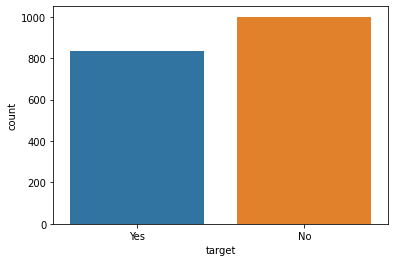

In [ ]:
#visualizing the label column of the df
def create_distribution(datafile):
    return sns.countplot(x='target', data= datafile)
create_distribution(merged_df)

In [ ]:
#converting the label column to digit
merged_df['target'] = merged_df['target'].replace(['No','Yes'],[0,1])

# Preprocess the raw dataset (Optional)

In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Convert to lower case and lemma the words in each conversation. Here we create a helper function that will be used to walkthrough the conversation table. The function will split the conversation into words

In [ ]:
# Preprocess the text with function processtext()
stop_words = stopwords.words('english')
punctuations = list(string.punctuation)
lemma = WordNetLemmatizer() # for Lemmatisation
stop_words.extend(['hello', 'hi', 'hey', 'heeeeeeeey', 'ok', 'babe','heyyyy', 'baby'])

def processtext(text):
    text=re.sub("[^a-zA-Z]"," ",text) # Filter to allow only alphabets in text
    text=text.lower() # Convert the text to lowercase to maintain consistency
    tokens=word_tokenize(text) # Tokenize the text
    # Remove stopwords and punctuations
    tokens=[token for token in tokens if token not in stop_words and token not in punctuations] 
    tokens=[lemma.lemmatize(token) for token in tokens] # Lemmatisation of tokens
    text=" ".join(tokens)
    return text
merged_df["conversation_messages"] = merged_df.conversation_messages.apply(lambda x: processtext(x))

In [ ]:
merged_df["conversation_messages"].head(20)

0     wut sup justin wats nothin bored bout u yea wu...
1     mmm nap rock im bored entertain lee guess late...
2     tried callin u u try day said u service yeah c...
3     oh sry thought u another stoopid bot hate yea ...
4     sexy hay im glad see u awww cant stay long mom...
5     r u missed u really honey r u kinda sleepy wak...
6     know u doi u want idk asl horny f ky wheres ho...
7     sweetheart home alone cousin im babysitting sl...
8     member puppy yes r u k u good kewl wat u doin ...
9     love sorry la grande oregon road opened madi c...
10    u u nothing u nohting u still grounded complet...
11    sexy little slut good hpw r u horny hehe u alw...
12    wont u sure sure date call okay guess tomorrow...
13    asl lansing oh f se mi k ur kinda cut looking ...
14    try calling yea sorry shower mom went store go...
15    msg anytime want call talk tomorrow heya sup c...
16    im dear sweet pretty cute ie kind candy u get ...
17    u nothing dang wish could party lol would 

In [ ]:
#splitting the dataframe into train and test 
X = merged_df["text"]
y = merged_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify=y)
# X_train, X_test = (merged_df, test_size = 0.2, random_state = 42, stratify=y)

In [ ]:
#dropping the ID column
merged_df.drop(columns=['conversation_id'], inplace= True)

#resetting the index of the dataframe
merged_df = merged_df.reset_index(drop=True)

# Text Classification using GPT2

In [ ]:
#installing transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 36.3 MB/s 
     |████████████████████████████████| 120 kB 69.5 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 


In [ ]:
#splitting the dataframe into train and test
train_size = int(0.8 * len(merged_df))
test_size = len(merged_df) - train_size
train, test = torch.utils.data.random_split(merged_df, [train_size, test_size])

In [ ]:
#importing necessary GPT2 libraries
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

#configuring our gpt2 models for binary classification
model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) 
#initializing the gpt2 model
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

#using the pretrained gpt2 tokenizer on the dataset
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class PredatorDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.train = train
        self.data = merged_df
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['text']
        return {'text': text, 'label': record['target']}

train_dataset = PredatorDataset(train=True)
test_dataset = PredatorDataset(train=False)

In [ ]:
for i in range(10):
    print(test_dataset.__getitem__(i)['text'])


someone is bored with me BIG TIME am not are too :) am not sob :) lol a bratty shark a sexy person talking to me about sharks lol :) 8-| man your friends must be really inetersting tonight then if you arent bored with me lol lol what ya wanna chat bout? ummmmm I dunno, what do you feel like idk chess, checkers, music, movies, dancing, relationships, fishing, sex lol u pick NOPE sexy girl pics i always gotta pick I like you to be in charge :) lol I do :) movies your the boss movies movies movies lol ok, what movie would you like to discuss idk you will think all the movies I like are "boring" sharks ya oohhh that one my granpa likes which one was bout a shark n it was eatin people n was like really dum i cant remember what is ccalled its like real old movie jaws jaws? so dorky ya!! thats it no, at the time, back then, it was the biggest grossing movie of all time and was so scary people literally freaked out.... lol like it dont even look real now it doesnt, back then that was as close 

In [ ]:
merged_df.columns

Index(['text', 'target'], dtype='object')

In [ ]:
#Data Collator used for GPT2 in a classificaiton task. It uses a given tokenizer and label encoder to convert any text and labels to numbers that can go straight into a GPT2 model.

class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                        max_seq_len=60)

In [ ]:

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=gpt2classificationcollator)

In [ ]:
from transformers import AdamW, get_cosine_schedule_with_warmup

total_epochs = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-5,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1) 

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

In [ ]:
# Train pytorch model on a single pass through the data loader.It will use the global variable `model` which is the transformer model loaded on `_device` that we want to train on

def train(dataloader, optimizer, scheduler, device_):
    # Use global variable for model.
    global model
    model.train()
    # Tracking variables.
    prediction_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = []
    # For each batch of training data...
    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
         # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        outputs = model(**batch)
        #  The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())
          # Always clear any previously calculated gradients before performing a backward pass
        optimizer.zero_grad()
        #backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
         # Update the learning rate
        scheduler.step()
         # Convert these logits to list of predicted labels values.
        prediction_labels += logits.argmax(axis=-1).flatten().tolist()

        # # Calculate the average loss over the training data.
        # avg_epoch_loss = total_loss / len(dataloader)

    
    return true_labels, prediction_labels, total_loss

    
def validation(dataloader, device_):
      # Use global variable for model.
    global model
    model.eval()
    
    prediction_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = []
    
    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]

            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        
    return true_labels, prediction_labels, total_loss


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}


for epoch in range(total_epochs):
    y_true, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)
    y, y_pred, val_loss = validation(test_dataloader, device)
    
    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss
    
    # all_acc['train_acc'].append(train_acc)
    # all_acc['val_acc'].append(val_acc)
    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f},val_loss: {torch.tensor(val_loss).mean():.3f}')
    
    # print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}') 

Epoch: 0, train_loss: 0.400,val_loss: 0.283
Epoch: 1, train_loss: 0.177,val_loss: 0.256
Epoch: 2, train_loss: 0.131,val_loss: 0.145
Epoch: 3, train_loss: 0.098,val_loss: 0.144
Epoch: 4, train_loss: 0.097,val_loss: 0.226
Epoch: 5, train_loss: 0.092,val_loss: 0.184
Epoch: 6, train_loss: 0.078,val_loss: 0.173
Epoch: 7, train_loss: 0.070,val_loss: 0.166
Epoch: 8, train_loss: 0.068,val_loss: 0.164
Epoch: 9, train_loss: 0.085,val_loss: 0.163


# Text Classifcation using BERT

In [ ]:
#mporting necessary libraries
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  


In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')

#load the bert tokenzer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
max_seq_len = 512

In [ ]:
#splitting the dataframe into train and test 
X = merged_df["text"]
y = merged_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify=y)
# X_train, X_test = (merged_df, test_size = 0.2, random_state = 42, stratify=y)

In [ ]:

tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len, 
    pad_to_max_length =True,
    truncation =True,
    return_tensors = 'pt',
    return_token_type_ids = False
)


tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len, 
    pad_to_max_length =True,
    truncation =True,
    return_tensors = 'pt',
    return_token_type_ids = False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

#for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recomm

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batchsize
batch_size = 64

#combine tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

#sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

#dataloader for trainset
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

In [ ]:
#combine tensors for test
test_data = TensorDataset(test_seq, test_mask, test_y)

#sampler for sampling the data during training
test_sampler = RandomSampler(test_data)

#dataloader for testset
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size)

In [ ]:
for param in bert.parameters():
  param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):
    super(BERT_Arch, self).__init__()
    self.bert = bert
    #dropout layer
    self.dropout = nn.Dropout(0.1)
    #relu activation function
    self.relu = nn.ReLU()
    #dense layers
    self.fc1 = nn.Linear(768, 512)
    self.fc2 = nn.Linear(512, 2)
    #activation function
    self.softmax = nn.LogSoftmax(dim=1)
    #define the forward pass

  def forward(self, sent_id, mask):
    #pass the inputs to the model
    result = self.bert(sent_id, attention_mask = mask)
    last_hidden_state = result[0][:,-1,:]
    output = last_hidden_state.reshape(-1, last_hidden_state.shape[-1])
    output = self.fc1(output)
    output = self.relu(output)
    output = self.dropout(output)
    #output layer
    output = self.fc2(output)
    #apply softmax activation
    output = self.softmax(output)

    return output


In [ ]:
#pass the pretrained bert into our architecture
model = BERT_Arch(bert)

model = model.to(device)

In [ ]:
#loss function
cross_entropy = nn.NLLLoss()
#optimize from hugging face transformers
from transformers import AdamW
#define the optmizer
optimizer = AdamW(model.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# function to train the model
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss += loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
#function for evaluating the model
def evaluate():
  print("\nEvaluating.....")
  #deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0,0
  #empty list to save the model predictions
  total_preds = []
  #iterate over batches
  for step, batch in enumerate(test_dataloader):
    #progress update every 50 batches
    if step % 50 ==0 and not step ==0:
      #report progress
      print(' Batch {:>5,} of {:>5,}. '.format(step, len(test_dataloader)))
    #push the batch to the gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    #deactivate autograd
    with torch.no_grad():
      #model predictions
      preds = model(sent_id, mask)
      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)
      #aoc value goes in here
      total_loss += loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  #compute the validation loss of the epoch
  avg_loss = total_loss /  len(test_dataloader)

  #reshape the predictions in form of (number of samples, no. of classes)
  total_preds = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [ ]:
epochs = 10
#set initial loss to infinite
best_valid_loss = float('inf')
#empty list to store training and validation loss of each epoch
train_losses = []
valid_losses = []

#for eaxh epoch
for epoch in range(epochs):
  print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
  #train model
  train_loss, _ = train()
  #evaluate model
  valid_loss, _ = evaluate()
  #save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_model.pt')

  #append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining loss: {train_loss:.3f}')
  print(f'\nVaidation loss: {valid_loss:.3f}')


 Epoch1 / 10

Evaluating.....

Training loss: 0.262

Vaidation loss: 0.140

 Epoch2 / 10

Evaluating.....

Training loss: 0.107

Vaidation loss: 0.128

 Epoch3 / 10

Evaluating.....

Training loss: 0.084

Vaidation loss: 0.102

 Epoch4 / 10

Evaluating.....

Training loss: 0.065

Vaidation loss: 0.099

 Epoch5 / 10

Evaluating.....

Training loss: 0.074

Vaidation loss: 0.117

 Epoch6 / 10

Evaluating.....

Training loss: 0.068

Vaidation loss: 0.118

 Epoch7 / 10

Evaluating.....

Training loss: 0.058

Vaidation loss: 0.090

 Epoch8 / 10

Evaluating.....

Training loss: 0.054

Vaidation loss: 0.100

 Epoch9 / 10

Evaluating.....

Training loss: 0.053

Vaidation loss: 0.109

 Epoch10 / 10
